In [5]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle
import cvxpy as cp
import os, json, joblib
import tensorflow as tf
import pickle
import random as rnd

plt.style.use("seaborn-v0_8")

np.random.seed(42)
rnd.seed(42)
tf.random.set_seed(42)

In [ ]:
MODEL_DIR = r"E:\models\ResNet_Simple2_v2"
DATA_PATH = r"E:\data\stock_prices.csv"

# =========================
# LOAD ARTIFACTS
# =========================
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, "resnet_model.h5"), compile=False)

with open(os.path.join(MODEL_DIR, "price_scalers.pkl"), "rb") as f:
    scalers = pickle.load(f) 

with open(os.path.join(MODEL_DIR, "scX.pkl"), "rb") as f:
    scX = pickle.load(f)  

with open(os.path.join(MODEL_DIR, "garch_static_df.pkl"), "rb") as f:
    garch_static_df = pickle.load(f)

with open(os.path.join(MODEL_DIR, "metadata.pkl"), "rb") as f:
    meta = pickle.load(f)

with open(os.path.join(MODEL_DIR, "feat_columns.pkl"), "rb") as f:
    feat_columns = pickle.load(f)

assets = meta["assets"]
print("Assets:", assets)

Assets: ['VOO', 'MSFT', 'AMZN', 'AVGO', 'VZ', 'XOM', 'CVX', 'CAT', 'SCHD', 'PG']


In [7]:
px = pd.read_csv(DATA_PATH, index_col="date", parse_dates=True)[assets]
px = px.sort_index()
print("px shape:", px.shape)

px shape: (1950, 10)


In [8]:

# ============================================================
# FEATURE REBUILD
# ============================================================
def rebuild_features(px, meta, garch_df, feat_cols):
    lag_r = meta["best_lags_r"]
    lag_v = meta["best_lags_v"]

    rets = np.log(px).diff().dropna()
    mret = rets.median(axis=1)

    lags_r = pd.concat(
        [mret.shift(i).rename(f"mret_t-{i}") for i in range(1, lag_r + 1)],
        axis=1
    )

    vol20 = mret.rolling(20).std()
    lags_v = pd.concat(
        [vol20.shift(i).rename(f"vol20_t-{i}") for i in range(1, lag_v + 1)],
        axis=1
    )

    vol_s = mret.rolling(5).std()
    q = vol_s.quantile([0.33, 0.66])

    regimes = pd.DataFrame({
        "reg_low":  (vol_s <= q.iloc[0]).astype(int),
        "reg_mid": ((vol_s > q.iloc[0]) & (vol_s <= q.iloc[1])).astype(int),
        "reg_high": (vol_s > q.iloc[1]).astype(int),
    })

    market_mean = px.mean(axis=1)
    px_dm = (market_mean - market_mean.rolling(120, min_periods=30).mean()).rename("market_lvl_dm")
    ema20 = market_mean.ewm(span=20, min_periods=10).mean().rename("market_ema20")

    feat = pd.concat([lags_r, lags_v, regimes, px_dm, ema20, garch_df], axis=1)

    # enforce exact training column order
    feat = feat.reindex(columns=feat_cols)
    feat = feat.reindex(px.index).ffill()
    feat = feat.dropna()

    return feat

feat_full = rebuild_features(px, meta, garch_static_df, feat_columns)
print(feat_full.shape)

(1920, 65)


In [9]:
# ============================================================
# ALIGN PX WITH FEATURES (CRITICAL FIX)
# ============================================================
px_aligned = px.loc[feat_full.index]

# ============================================================
# SCALE INPUTS
# ============================================================
X_main_all = scX.transform(feat_full)

X_skip_all = np.column_stack([
    scalers[a].transform(px_aligned[[a]]).flatten()
    for a in assets
])

print("X_main_all:", X_main_all.shape)
print("X_skip_all:", X_skip_all.shape)
print("Index equal check:", 
      np.all(feat_full.index == px_aligned.index))


# ------------------------------------------------------------
# MAKE 20-DAY WINDOWS (AS IN TRAINING)
# ------------------------------------------------------------
SEQ = 20

X_main_seq = np.array([
    X_main_all[i-SEQ:i].reshape(-1)
    for i in range(SEQ, len(X_main_all))
])

X_skip_seq = X_skip_all[SEQ:]
idx_pred   = feat_full.index[SEQ:]

print("\n=== SEQUENCE SHAPES ===")
print("X_main_seq:", X_main_seq.shape)
print("X_skip_seq:", X_skip_seq.shape)
print("idx_pred:", idx_pred.shape)


# ============================================================
# ONE-STEP-AHEAD POINT FORECAST (PRICES)
# ============================================================
Y_hat_sc = model.predict([X_main_seq, X_skip_seq], verbose=0)

y_pred_all = pd.DataFrame(
    np.column_stack([
        scalers[a].inverse_transform(
            Y_hat_sc[:, j].reshape(-1,1)
        ).flatten()
        for j,a in enumerate(assets)
    ]),
    index=idx_pred,
    columns=assets
)

print("\n=== PREDICTIONS ===")
print("y_pred_all:", y_pred_all.shape)


# ============================================================
# RETURNS (POINT FORECAST vs REALIZED)
# ============================================================
P_t = px[assets].reindex(y_pred_all.index)
P_1 = px[assets].shift(-1).reindex(y_pred_all.index)

r_hat_df  = (y_pred_all - P_t) / P_t
r_real_df = (P_1 - P_t) / P_t

common_idx = r_hat_df.dropna().index.intersection(
    r_real_df.dropna().index
)

r_hat_df  = r_hat_df.loc[common_idx]
r_real_df = r_real_df.loc[common_idx]

print("\n=== RETURNS ===")
print("r_hat_df:", r_hat_df.shape)
print("r_real_df:", r_real_df.shape)


# ============================================================
# HISTORICAL RETURNS (FOR COVARIANCE)
# ============================================================
rets_all = px[assets].pct_change().dropna()

print("\n=== HISTORICAL RETURNS ===")
print("rets_all:", rets_all.shape)


X_main_all: (1920, 65)
X_skip_all: (1920, 10)
Index equal check: True

=== SEQUENCE SHAPES ===
X_main_seq: (1900, 1300)
X_skip_seq: (1900, 10)
idx_pred: (1900,)


c:\Users\zedax\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(



=== PREDICTIONS ===
y_pred_all: (1900, 10)

=== RETURNS ===
r_hat_df: (1899, 10)
r_real_df: (1899, 10)

=== HISTORICAL RETURNS ===
rets_all: (1949, 10)


In [10]:
# ------------------------------------------------------------
# 5. MARKOWITZ MIN-VAR 
# ------------------------------------------------------------
def make_psd(S, eps=1e-8):
    S = 0.5*(S + S.T)
    w, V = np.linalg.eigh(S)
    w = np.maximum(w, eps)
    return (V*w) @ V.T

def markowitz_minvar(mu, Sigma, allow_short, target_return=None):

    Sigma = make_psd(Sigma)
    n = len(mu)
    w = cp.Variable(n)

    cons = [cp.sum(w) == 1]

    if not allow_short:
        cons.append(w >= 0)

    if target_return is not None:
        cons.append(mu @ w >= target_return)

    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), cons)
    prob.solve(solver=cp.SCS)

    if w.value is None:       
        return np.ones(n)/n

    return np.array(w.value).ravel()


# ------------------------------------------------------------
# 6. ROLLING RESNET → MARKOWITZ (H+1, daily-style rebalance)
# ------------------------------------------------------------
def rolling_resnet_markowitz_H1(
    r_hat_df, r_real_df, rets_all, assets,
    lookback=252,
    allow_short=False,
    use_return_constraint=True
):
    records = []

    for t in r_hat_df.index:

        hist = rets_all.loc[:t].tail(lookback)
        if hist.shape[0] < lookback or t not in r_real_df.index:
            continue

        mu = r_hat_df.loc[t].values.astype(float)
        Sigma = make_psd(hist.cov(ddof=0).values)

        if np.any(np.isnan(mu)) or np.any(np.isnan(Sigma)):
            continue

        target_ret = mu.mean() if use_return_constraint else None

        w = markowitz_minvar(mu, Sigma, allow_short, target_ret)
        r_real = r_real_df.loc[t].values.astype(float)

        records.append({
            "date": t,
            "ret_real": float(w @ r_real),
            "vol_annual": float(np.sqrt(w @ Sigma @ w) * np.sqrt(252)),
            "mu_vec": mu,
            "weights": dict(zip(assets, w))
        })

    return pd.DataFrame(records).set_index("date")


results_resnet = rolling_resnet_markowitz_H1(
    r_hat_df=r_hat_df,
    r_real_df=r_real_df,
    rets_all=rets_all,
    assets=assets,
    lookback=252,
    allow_short=False,
    use_return_constraint=True
)

print("ResNet H+1 → Markowitz results:", results_resnet.shape)
results_resnet.head()

ResNet H+1 → Markowitz results: (1697, 4)


,ret_real,vol_annual,mu_vec,weights
date,,,,
2019-01-03,0.022723,0.145057,"[-0.39208612971857415, -2.4555707606504713, -1...","{'VOO': 0.28822688433604354, 'MSFT': -1.010268..."
2019-01-04,0.004193,0.146773,"[-0.0537897562298074, 1.2925590460188208, -1.3...","{'VOO': 0.2493213807835047, 'MSFT': -8.8699860..."
2019-01-07,0.011598,0.147233,"[-0.038752228504982944, 1.584957011848431, 1.7...","{'VOO': 0.13892109125823845, 'MSFT': 4.7983597..."
2019-01-08,-0.001776,0.152103,"[0.12518367655786222, -2.943748442549187, 2.67...","{'VOO': 0.104435918858853, 'MSFT': 1.073042328..."
2019-01-09,0.004313,0.147328,"[1.1935388084966594, 0.5636947376747091, -0.63...","{'VOO': 0.25898269303258353, 'MSFT': -5.613020..."


=== ResNet Model 3  Markowitz (Horizon) ===
Total return: 0.7512361666976235
Annualized vol: 0.15234871338890424
Sharpe: 0.6224136818217845
Sortino: 0.8124603162941002
Max Drawdown: -0.22327942335719086


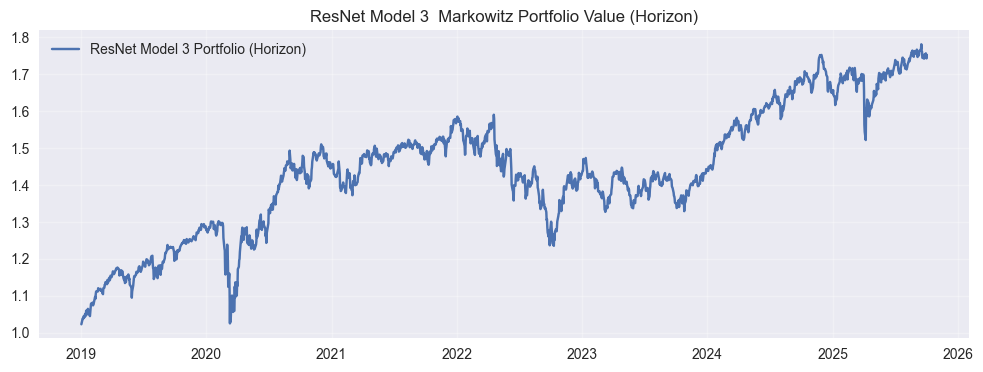

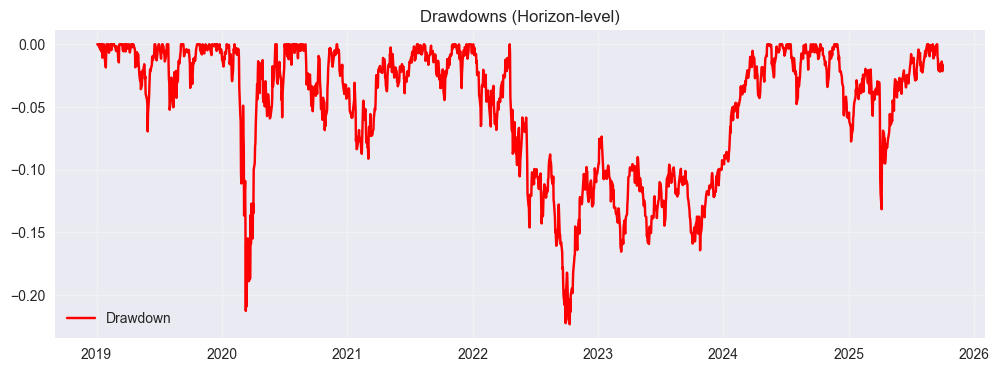

In [11]:
# ============================================================
# 5. HORIZON-LEVEL PORTFOLIO (RESNET MODEL 3)
# ============================================================

step_ret  = results_resnet["ret_real"].fillna(0.0)
portfolio = (1 + step_ret).cumprod()

def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd

total_return = portfolio.iloc[-1] - 1.0
vol         = step_ret.std() * np.sqrt(252)
sharpe  = step_ret.mean() / (step_ret.std() + 1e-12) * np.sqrt(252)
sortino = step_ret.mean() / (step_ret[step_ret < 0].std() + 1e-12) * np.sqrt(252)
mdd, dd     = max_drawdown(portfolio)

print("=== ResNet Model 3  Markowitz (Horizon) ===")
print("Total return:", total_return)
print("Annualized vol:", vol)
print("Sharpe:", sharpe)
print("Sortino:", sortino)
print("Max Drawdown:", mdd)

plt.figure(figsize=(12,4))
plt.plot(results_resnet.index, portfolio, label="ResNet Model 3 Portfolio (Horizon)")
plt.grid(alpha=0.3)
plt.legend()
plt.title("ResNet Model 3  Markowitz Portfolio Value (Horizon)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(results_resnet.index, dd, color="red", label="Drawdown")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Drawdowns (Horizon-level)")
plt.show()

In [12]:
# ============================================================
# 6. CONVERT RESNET PORTFOLIO TO MONTHLY 
# ============================================================

portfolio_daily = portfolio.copy()
portfolio_monthly = portfolio_daily.resample("ME").last()
r_monthly = portfolio_monthly.pct_change().dropna()

tot_ret_m = portfolio_monthly.iloc[-1] / portfolio_monthly.iloc[0] - 1.0
vol_m     = r_monthly.std() * np.sqrt(12)
sharpe_m  = r_monthly.mean() / (r_monthly.std() + 1e-12) * np.sqrt(12)
sortino_m = r_monthly.mean() / (r_monthly[r_monthly < 0].std() + 1e-12) * np.sqrt(12)
mdd_m, dd_m = max_drawdown(portfolio_monthly)

print("=== ResNet Model 3 → Markowitz (Monthly) ===")
print("Total return:", tot_ret_m)
print("Annual vol:",   vol_m)
print("Sharpe:",       sharpe_m)
print("Sortino:",      sortino_m)
print("Max DD:",       mdd_m)
print("Monthly start:", portfolio_monthly.index[0])

=== ResNet Model 3 → Markowitz (Monthly) ===
Total return: 0.6247373718212736
Annual vol: 0.13041184730836564
Sharpe: 0.6170154122560755
Sortino: 1.0349940896672771
Max DD: -0.19206177756295761
Monthly start: 2019-01-31 00:00:00


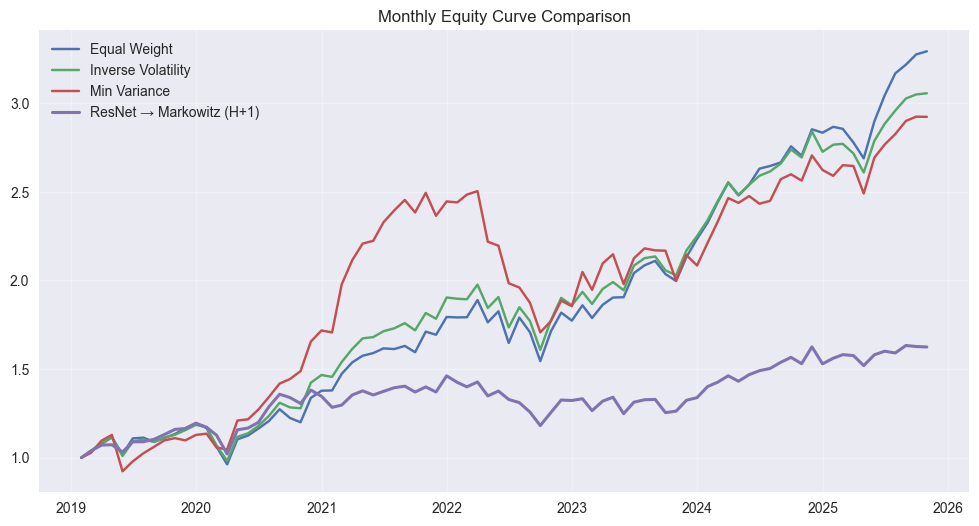

In [13]:
# ------------------------------------------------------------
# MONTHLY benchmark returns from prices
# ------------------------------------------------------------
px_monthly  = px[assets].resample("ME").last()
retm_assets = px_monthly.pct_change().dropna()

def run_strategy_bench(retm_assets: pd.DataFrame, method="EW", lookback=6):
    cols = retm_assets.columns
    eq_vals = []
    rets = []
    idx_list = []
    weights_rec = []

    for t in range(lookback, len(retm_assets)):
        window = retm_assets.iloc[t-lookback:t]

        if method == "EW":
            w = np.ones(len(cols)) / len(cols)

        elif method == "IVOL":
            vol = window.std(ddof=0)
            inv = 1 / vol.replace(0, np.nan)
            w = (inv / inv.sum()).fillna(0.0).values

        elif method == "MVP":
            Sigma = make_psd(window.cov(ddof=0).values)
            n = len(cols)
            w_var = cp.Variable(n)
            prob = cp.Problem(
                cp.Minimize(cp.quad_form(w_var, Sigma)),
                [cp.sum(w_var) == 1, w_var >= 0]
            )
            prob.solve(solver=cp.SCS)
            w = np.array(w_var.value).ravel()

        r = retm_assets.iloc[t].values
        port_ret = float(r @ w)

        rets.append(port_ret)
        if len(eq_vals) == 0:
            eq_vals.append(1 * (1 + port_ret))
        else:
            eq_vals.append(eq_vals[-1] * (1 + port_ret))

        idx_list.append(retm_assets.index[t])
        weights_rec.append(w)

    eq = pd.Series(eq_vals, index=idx_list)
    r  = pd.Series(rets,    index=idx_list)
    w_df = pd.DataFrame(weights_rec, index=idx_list, columns=cols)
    return eq, r, w_df


LOOKBACK = 6
eq_EW,   r_EW,   w_EW   = run_strategy_bench(retm_assets, "EW",   LOOKBACK)
eq_IVOL, r_IVOL, w_IVOL = run_strategy_bench(retm_assets, "IVOL", LOOKBACK)
eq_MVP,  r_MVP,  w_MVP  = run_strategy_bench(retm_assets, "MVP",  LOOKBACK)

common_idx = portfolio_monthly.index.intersection(eq_EW.index)

plt.figure(figsize=(12,6))
plt.plot(eq_EW.loc[common_idx]   / eq_EW.loc[common_idx].iloc[0],   label="Equal Weight")
plt.plot(eq_IVOL.loc[common_idx] / eq_IVOL.loc[common_idx].iloc[0], label="Inverse Volatility")
plt.plot(eq_MVP.loc[common_idx]  / eq_MVP.loc[common_idx].iloc[0],  label="Min Variance")
plt.plot(portfolio_monthly.loc[common_idx] / portfolio_monthly.loc[common_idx].iloc[0],
         label="ResNet → Markowitz (H+1)", linewidth=2.2)

plt.legend()
plt.grid(alpha=0.3)
plt.title("Monthly Equity Curve Comparison")
plt.show()

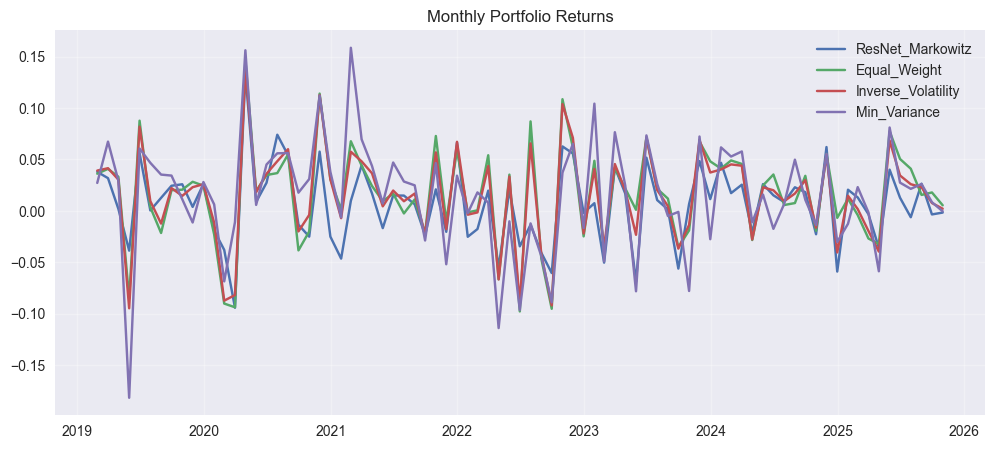

In [14]:
# ============================================================
# 9. MONTHLY RETURNS — RESNET vs EW / IVOL / MVP
# ============================================================
r_RESNET = portfolio_monthly.pct_change().dropna()
r_RESNET.name = "ResNet_Markowitz"

r_EW.name   = "Equal_Weight"
r_IVOL.name = "Inverse_Volatility"
r_MVP.name  = "Min_Variance"

ret_monthly_df = pd.concat([r_RESNET, r_EW, r_IVOL, r_MVP], axis=1).dropna()

plt.figure(figsize=(12,5))
for col in ret_monthly_df.columns:
    plt.plot(ret_monthly_df.index, ret_monthly_df[col], label=col)
plt.grid(alpha=0.3)
plt.legend()
plt.title("Monthly Portfolio Returns")
plt.show()

In [15]:
# ============================================================
# 9. PERFORMANCE TABLE (Monthly frequency)
# ============================================================
def perf_metrics(eq: pd.Series):
    r = eq.pct_change().dropna()
    total   = eq.iloc[-1]/eq.iloc[0] - 1
    vol     = r.std() * np.sqrt(12)
    sharpe  = r.mean()/r.std() * np.sqrt(12)
    sortino = r.mean()/r[r < 0].std() * np.sqrt(12)
    mdd     = (eq/eq.cummax() - 1).min()
    return total, vol, sharpe, sortino, mdd

strategies = {
    "ResNet → Markowitz (H+1)": portfolio_monthly.loc[common_idx],
    "Equal Weight":   eq_EW.loc[common_idx],
    "Inverse Vol":    eq_IVOL.loc[common_idx],
    "Min Variance":   eq_MVP.loc[common_idx],
}

rows = {name: perf_metrics(eq) for name, eq in strategies.items()}

summary = pd.DataFrame.from_dict(
    rows, orient="index",
    columns=["Total Return","Volatility","Sharpe","Sortino","Max Drawdown"]
).round(4)

summary

,Total Return,Volatility,Sharpe,Sortino,Max Drawdown
ResNet → Markowitz (H+1),0.6247,0.1304,0.6170,1.0350,-0.1921
Equal Weight,2.2937,0.1638,1.1663,1.7617,-0.1945
Inverse Vol,2.0566,0.1568,1.1399,1.7069,-0.1863
Min Variance,1.9235,0.1895,0.9389,1.2047,-0.3183


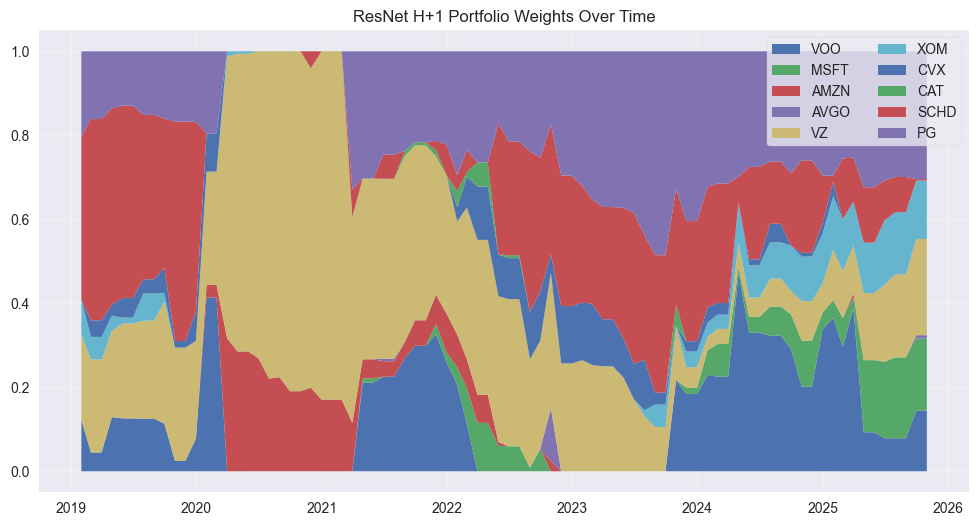

In [ ]:
# ============================================================
# 10. WEIGHTS OVER TIME (ResNet H+1 portfolio)
# ============================================================

weights_df = pd.DataFrame(results_resnet["weights"].tolist(),index=results_resnet.index)
weights_df = weights_df.reindex(portfolio_monthly.index).ffill()

plt.figure(figsize=(12,6))
plt.stackplot(weights_df.index,weights_df.T,labels=weights_df.columns)
plt.legend(loc="upper right",ncol=2,fontsize=10,frameon=True)
plt.grid(alpha=0.3)
plt.title("ResNet-GARCH (Model 3) Portfolio Weights Over Time")
plt.show()

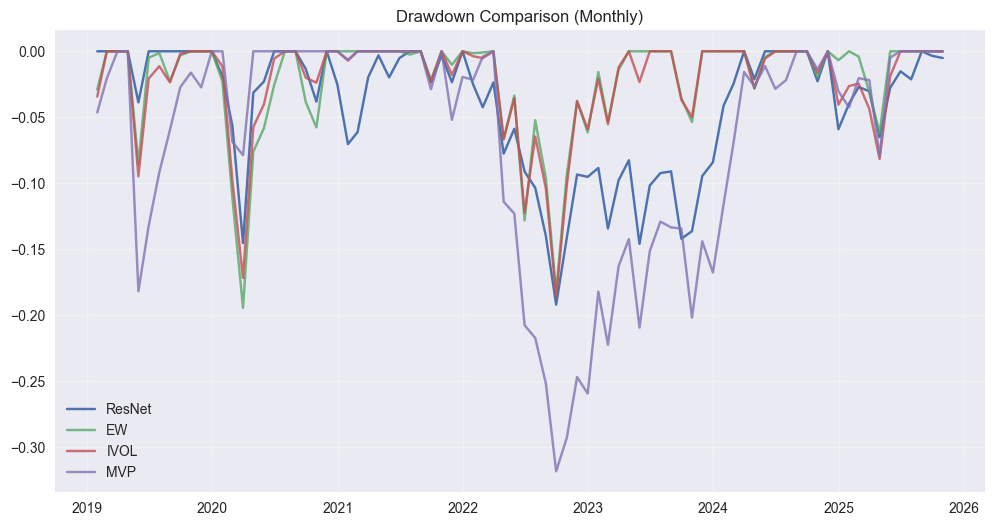

In [17]:
# ============================================================
# X3. Drawdowns Comparison (Monthly)
# ============================================================

def drawdown_series(eq: pd.Series):
    roll_max = eq.cummax()
    return eq / roll_max - 1.0

dd_RESNET = drawdown_series(portfolio_monthly)
dd_EW     = drawdown_series(eq_EW)
dd_IVOL   = drawdown_series(eq_IVOL)
dd_MVP    = drawdown_series(eq_MVP)

common_idx = dd_RESNET.index.intersection(dd_EW.index)\
                            .intersection(dd_IVOL.index)\
                            .intersection(dd_MVP.index)

plt.figure(figsize=(12,6))
plt.plot(common_idx, dd_RESNET.loc[common_idx], label="ResNet")
plt.plot(common_idx, dd_EW.loc[common_idx],     label="EW",   alpha=0.8)
plt.plot(common_idx, dd_IVOL.loc[common_idx],   label="IVOL", alpha=0.8)
plt.plot(common_idx, dd_MVP.loc[common_idx],    label="MVP",  alpha=0.8)
plt.legend()
plt.grid(alpha=0.3)
plt.title("Drawdown Comparison (Monthly)")
plt.show()

In [19]:
# ---------------- SAVE: EQUITY CURVES ----------------
df_eq = pd.concat([portfolio_monthly.rename("ResNet"),eq_EW.rename("EW"),eq_IVOL.rename("IVOL"),eq_MVP.rename("MVP")], axis=1)
df_eq.index.name = "date"
df_eq.to_csv(r"E:\data\Model3_data\equity_curves_monthly.csv")
df_eq

,ResNet,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,1.022298,1.029402,1.044997
2018-09-30,NaN,1.057340,1.057416,1.081762
2018-10-31,NaN,0.985129,0.992650,1.030988
2018-11-30,NaN,1.038227,1.040884,1.096703
2018-12-31,NaN,0.968780,0.967565,0.988280
...,...,...,...,...
2025-06-30,1.725505,3.125413,2.944709,2.893980
2025-07-31,1.714852,3.253611,3.021108,2.956056
2025-08-31,1.760211,3.304119,3.090866,3.033362


In [20]:
df_ret = pd.concat([r_RESNET.rename("ResNet"),r_EW.rename("EW"),r_IVOL.rename("IVOL"),r_MVP.rename("MVP")], axis=1)
df_ret.index.name = "date"
df_ret.to_csv(r"E:\data\Model3_data\returns_monthly.csv")
df_ret

,ResNet,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,0.022298,0.029402,0.044997
2018-09-30,NaN,0.034277,0.027214,0.035182
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,0.053899,0.048591,0.063740
2018-12-31,NaN,-0.066889,-0.070439,-0.098862
...,...,...,...,...
2025-06-30,0.012806,0.050508,0.034424,0.027462
2025-07-31,-0.006174,0.041018,0.025944,0.021450
2025-08-31,0.026451,0.015524,0.023090,0.026152


In [21]:
dd_df = pd.concat([dd_RESNET.rename("ResNet"),dd_EW.rename("EW"),dd_IVOL.rename("IVOL"),dd_MVP.rename("MVP")], axis=1)
dd_df.index.name = "date"
dd_df.to_csv(r"E:\data\Model3_data\drawdowns_monthly.csv")
dd_df

,ResNet,EW,IVOL,MVP
date,,,,
2018-08-31,NaN,0.000000,0.000000,0.000000
2018-09-30,NaN,0.000000,0.000000,0.000000
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,-0.018077,-0.015634,0.000000
2018-12-31,NaN,-0.083757,-0.084972,-0.098862
...,...,...,...,...
2025-06-30,-0.015177,0.000000,0.000000,0.000000
2025-07-31,-0.021257,0.000000,0.000000,0.000000
2025-08-31,0.000000,0.000000,0.000000,0.000000


In [22]:
weights_df.to_csv(r"E:\data\Model3_data\weights_resnet_monthly.csv", index_label="date")
weights_df

,VOO,MSFT,AMZN,AVGO,VZ,XOM,CVX,CAT,SCHD,PG
date,,,,,,,,,,
2019-01-31,0.122276,5.226347e-06,1.189938e-05,-6.180235e-08,0.203478,0.082835,-1.854425e-07,-1.043327e-06,0.388357,0.203038
2019-02-28,0.044629,1.779110e-07,5.765653e-07,1.680868e-08,0.221483,0.053864,3.950194e-02,-1.228229e-07,0.479162,0.161360
2019-03-31,0.044629,1.779110e-07,5.765653e-07,1.680868e-08,0.221483,0.053864,3.950194e-02,-1.228229e-07,0.479162,0.161360
2019-04-30,0.128975,6.878375e-06,1.010435e-05,-5.141434e-07,0.205367,0.036384,2.609472e-02,-1.298135e-06,0.467623,0.135542
2019-05-31,0.125836,1.055518e-05,1.498847e-05,-6.623156e-07,0.225965,0.014024,4.698091e-02,1.273138e-06,0.457866,0.129303
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.078609,1.818374e-01,1.237680e-06,6.616399e-06,0.184067,0.153324,-7.174411e-07,-1.415095e-06,0.094770,0.307386
2025-07-31,0.078545,1.927489e-01,-8.952043e-07,-4.263992e-06,0.197886,0.147698,4.039238e-07,6.849889e-07,0.083829,0.299298
2025-08-31,0.078545,1.927489e-01,-8.952043e-07,-4.263992e-06,0.197886,0.147698,4.039238e-07,6.849889e-07,0.083829,0.299298


In [23]:
print("\n" + "="*60)
print("MODEL 3 (ResNet Simple) — AUDIT SUMMARY")
print("="*60)

# --------------------------------------------------
# 1) ASSET UNIVERSE
# --------------------------------------------------
print("\n[ASSETS]")
print("N assets:", len(assets))
print("Assets list:", assets)

# --------------------------------------------------
# 2) PRICE DATA
# --------------------------------------------------
print("\n[PRICE DATA]")
print("px shape:", px.shape)
print("Date range:", px.index.min(), "→", px.index.max())
print("Columns match assets:",
      set(assets).issubset(px.columns))

# --------------------------------------------------
# 3) FEATURE MATRIX
# --------------------------------------------------
print("\n[FEATURE MATRIX]")
print("feat_full shape:", feat_full.shape)
print("Feature start/end:",
      feat_full.index.min(),
      feat_full.index.max())

# --------------------------------------------------
# 4) FORECAST MATRICES
# --------------------------------------------------
print("\n[FORECAST MATRICES]")
print("r_hat_df:", r_hat_df.shape)
print("r_real_df:", r_real_df.shape)

print("Forecast start/end:",
      r_hat_df.index.min(),
      r_hat_df.index.max())

# --------------------------------------------------
# 5) HISTORICAL RETURNS
# --------------------------------------------------
print("\n[HISTORICAL RETURNS]")
print("rets_all shape:", rets_all.shape)
print("rets_all start/end:",
      rets_all.index.min(),
      rets_all.index.max())

# --------------------------------------------------
# 6) ROLLING MARKOWITZ
# --------------------------------------------------
print("\n[ROLLING MARKOWITZ]")
print("results_resnet shape:", results_resnet.shape)
print("Start:", results_resnet.index.min())
print("End:", results_resnet.index.max())

# --------------------------------------------------
# 7) DAILY PORTFOLIO
# --------------------------------------------------
print("\n[DAILY PORTFOLIO]")
print("portfolio length:", len(portfolio))
print("Start:", portfolio.index.min())
print("End:", portfolio.index.max())

# --------------------------------------------------
# 8) MONTHLY PORTFOLIO
# --------------------------------------------------
print("\n[MONTHLY PORTFOLIO]")
print("portfolio_monthly length:", len(portfolio_monthly))
print("Monthly start:", portfolio_monthly.index.min())
print("Monthly end:", portfolio_monthly.index.max())

# --------------------------------------------------
# 9) BENCHMARK INPUT
# --------------------------------------------------
print("\n[BENCHMARK INPUT]")
print("retm_assets shape:", retm_assets.shape)
print("retm_assets start/end:",
      retm_assets.index.min(),
      retm_assets.index.max())

# --------------------------------------------------
# 10) BENCHMARK OUTPUTS
# --------------------------------------------------
print("\n[BENCHMARK OUTPUTS]")
print("EW length:", len(eq_EW),
      "| start:", eq_EW.index.min(),
      "| end:", eq_EW.index.max())

print("IVOL length:", len(eq_IVOL),
      "| start:", eq_IVOL.index.min(),
      "| end:", eq_IVOL.index.max())

print("MVP length:", len(eq_MVP),
      "| start:", eq_MVP.index.min(),
      "| end:", eq_MVP.index.max())

# --------------------------------------------------
# 11) ALIGNMENT CHECK
# --------------------------------------------------
print("\n[ALIGNMENT CHECK]")

common = portfolio_monthly.index.intersection(eq_EW.index)

print("Common months Model vs EW:", len(common))
print("Model start vs EW start:",
      portfolio_monthly.index.min(),
      eq_EW.index.min())

print("Model end vs EW end:",
      portfolio_monthly.index.max(),
      eq_EW.index.max())

# --------------------------------------------------
# 12) NaN CHECKS
# --------------------------------------------------
print("\n[NaN CHECKS]")

print("NaNs portfolio_monthly:",
      portfolio_monthly.isna().sum())

print("NaNs EW:", eq_EW.isna().sum())
print("NaNs IVOL:", eq_IVOL.isna().sum())
print("NaNs MVP:", eq_MVP.isna().sum())

print("\n" + "="*60)
print("END AUDIT")
print("="*60)



MODEL 3 (ResNet Simple) — AUDIT SUMMARY

[ASSETS]
N assets: 10
Assets list: ['VOO', 'MSFT', 'AMZN', 'AVGO', 'VZ', 'XOM', 'CVX', 'CAT', 'SCHD', 'PG']

[PRICE DATA]
px shape: (1950, 10)
Date range: 2018-01-02 00:00:00 → 2025-10-03 00:00:00
Columns match assets: True

[FEATURE MATRIX]
feat_full shape: (1920, 65)
Feature start/end: 2018-02-14 00:00:00 2025-10-03 00:00:00

[FORECAST MATRICES]
r_hat_df: (1899, 10)
r_real_df: (1899, 10)
Forecast start/end: 2018-03-15 00:00:00 2025-10-02 00:00:00

[HISTORICAL RETURNS]
rets_all shape: (1949, 10)
rets_all start/end: 2018-01-03 00:00:00 2025-10-03 00:00:00

[ROLLING MARKOWITZ]
results_resnet shape: (1697, 4)
Start: 2019-01-03 00:00:00
End: 2025-10-02 00:00:00

[DAILY PORTFOLIO]
portfolio length: 1697
Start: 2019-01-03 00:00:00
End: 2025-10-02 00:00:00

[MONTHLY PORTFOLIO]
portfolio_monthly length: 82
Monthly start: 2019-01-31 00:00:00
Monthly end: 2025-10-31 00:00:00

[BENCHMARK INPUT]
retm_assets shape: (93, 10)
retm_assets start/end: 2018-02-2